# 利用文字進行風格轉換
`作者: 湯沂達 <changethewhat@gmail.com>`<br>
<img src="https://replicate.com/api/models/mistake0316/style-transfer-clip/files/0f51aae9-ef91-4ee6-a83f-065abbb7a65c/doge.jpeg" width=100%><br>
<img src="https://i.imgur.com/akOYgrn.png" width=100%>

-----

![](https://camo.githubusercontent.com/cca8b41389584f0d6ed61603520386afc1db206abe6a19cfc8527f4a01f599d4/68747470733a2f2f692e696d6775722e636f6d2f4253323165366f2e706e67)<br>
回憶一下<font color="blue">一個模型服務任意風格(Arbitrary-Style-Per-Model:ASPM)</font>的方法，他們在做風格轉換時，不同風格影像對應不同的$\vec{S}$<br>
在這個範例中我捨棄了他們原生的風格預測模型，嘗試使用CLIP的模型來導引$\vec S$應該為何。<br>
在這方法中，要找到一個最好的S，使得$L_{CLIP}(T(c, \vec S), t)$最小<br>
<img src="https://i.imgur.com/akOYgrn.png" width=100%>
結果如圖示，輸入影像皆一致，而輸入文字從左到右的分別為
1. cheese cake
2. green and blue mosaic
3. Leopard (豹紋)
4. firework
5. bush
6. bubble tea
7. pancake
8. colorful pearls (顏色豐富的珍珠)

In [ ]:
try:
  import google.colab
  print("In Colab")
  %cd /content
  !git clone https://github.com/mistake0316/CLIPStyleTransfer.git
  %cd /content/CLIPStyleTransfer
except:
  print("Not in Colab")
  pass

try:
  gpu_config = !nvidia-smi
  print("\n".join(gpu_config))
except:
  print("without gpu")

In Colab
/content
fatal: destination path 'CLIPStyleTransfer' already exists and is not an empty directory.
/content/CLIPStyleTransfer
Tue Aug 23 21:02:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+

# Install & Import & Config

In [ ]:
#@title intsall
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fxyq8y3e
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-fxyq8y3e


In [ ]:
#@title import
import torch
import torchvision.transforms as T
from utils.stylePredictor26 import pretrainedStylePredictor
from utils.transform26 import pretrainedGhiasi

import clip
from utils.clip_loss import CLIPLoss
from PIL import Image

import torchvision.transforms as T
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

import imageio

In [ ]:
#@title config
resize_flag = True       #@param ["True", "False"] {type:"raw"}
center_crop_flag = True  #@param ["True", "False"] {type:"raw"}
content_cap = 384 #@param {type:"number"}
style_size = 256  #edit this will make wierd initial style

content_image_path = "doge.jpg" #@param {type:"string"}
optimize_steps = 100 #@param {type:"number"}
gif_frames = 30 #@param {type:"number"}

save_step = optimize_steps//gif_frames
clip_loss_weight = 1 #@param {type:"number"}
l2_loss_weight = 0 #@param {type:"number"}

save_folder = "result_with_aug" #@param {type:"string"}

lr = 0.01 #@param {type:"number"}

assert optimize_steps >= gif_frames
assert clip_loss_weight > 0
assert l2_loss_weight >= 0

# 資料擴增
![](https://i.imgur.com/gQJbGGK.png)<br>
> 概念來自 [CLIPDraw: Exploring Text-to-Drawing Synthesis
through Language-Image Encoders](https://arxiv.org/abs/2106.14843)

在影像分類任務中，對資料進行旋轉、平移、放大、縮小、擷取等等是一件非常常見的事情，因為在做完這件事情後，並不改變標籤（例如獅子還是獅子、汽車還是汽車）


而在這次的任務中，對影像進行資料擴增大部分算是合理<br>
例如若希望的文字是<font color=red>色彩豐富的馬賽克</font>進行影像的資料擴增，是很合理的事情<br>
但若是對<font color=red>黑白影像</font>進行顏色調整，或者對<font color=red>水平平行線</font>進行影像扭曲不是一件好事情。

此處就把資料擴增的程式碼留在下面，若結果不理想再自行更改吧！

In [ ]:
#@title Augmentator Config
aug_times = 32 #@param {type:"number"}

affine_param = dict()
affine_param["degrees"] = 180 #@param {type:"number"}
affine_param["shear"] = 5 #@param {type:"number"}
affine_param["scale"] = (1, 1.5) #@param {type:"raw"}

color_param = dict()
color_param["brightness"] = 0.1 #@param {type:"number"}
color_param["contrast"] = 0.1 #@param {type:"number"}
color_param["saturation"] = 0.1 #@param {type:"number"}
color_param["hue"] = 0.1 #@param {type:"number"}

Aug = torch.nn.Sequential(
  T.RandomAffine(
    degrees=affine_param["degrees"],
    shear=affine_param["shear"],
    scale=affine_param["scale"],
  ),
  T.ColorJitter(
    brightness=color_param["brightness"],
    contrast=color_param["contrast"],
    saturation=color_param["saturation"],
    hue=color_param["hue"],
  ),
  T.RandomCrop(content_cap),
)

aug_fun = lambda img: torch.cat([Aug(img) for _ in range(aug_times)])

In [ ]:
#@title load models
print("loading models")
device = ["cpu", "cuda"][torch.cuda.is_available()]
print(f"device : {device}")
SP = pretrainedStylePredictor().to(device).eval()
G = pretrainedGhiasi().to(device).eval()
clip_loss = CLIPLoss(content_cap, device).eval()
print("done")

loading models
device : cuda


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 113MiB/s]


done


In [ ]:
#@title define preprocesser
style_preprocess = torch.nn.Sequential(
  T.Resize(style_size,),
  T.CenterCrop(style_size),
  torch.nn.AvgPool2d(kernel_size=3,stride=1)
)

content_preprocess = torch.nn.Sequential()
if resize_flag:
  content_preprocess.add_module("resize", T.Resize(content_cap,))
if center_crop_flag:
  content_preprocess.add_module("center_crop",T.CenterCrop(content_cap),)

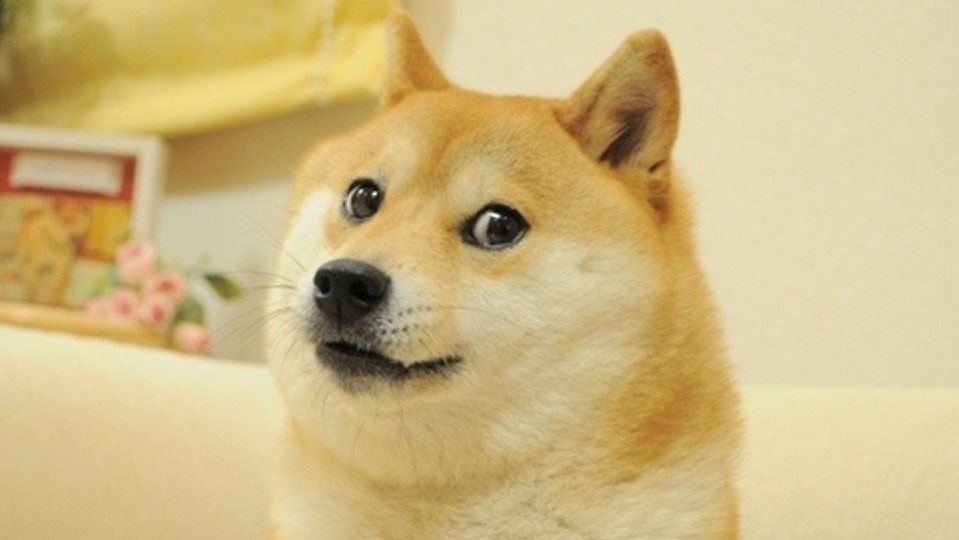

In [ ]:
content = Image.open(content_image_path).convert('RGB')
content

# Go get encode

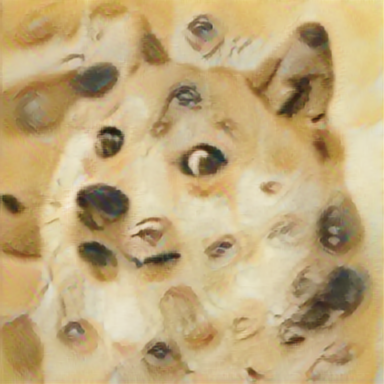

In [ ]:
#@title reconstruct with Ghiasi's style transfer model

content_tensor = T.ToTensor()(content)
content_tensor = content_preprocess(content_tensor)

style_tensor = T.ToTensor()(content)
style_tensor = style_preprocess(style_tensor)

content_tensor = content_tensor.unsqueeze(0).to(device)
style_tensor = style_tensor.unsqueeze(0).to(device)
with torch.no_grad():
  style_code = SP(style_tensor)
  result = G(content_tensor, style_code)

T.ToPILImage()(result.squeeze().cpu())

# Go CLIP

In [ ]:
def tensor_to_numpy_image(tensor):
  return (255*tensor.detach().squeeze().cpu().permute(1,2,0).numpy()).astype(np.uint8)

In [ ]:
text_list = """\
black and white mosaic
colorful pearls
starry night
pancake"""

In [ ]:
from pathlib import Path
Path(save_folder).mkdir(parents=True, exist_ok=True)

#CLIP Loss
在進入主要程式碼之前，可以先看一下CLIP_loss怎麼設計的
```python
# this code is modified from StyleCLIP
# https://github.com/orpatashnik/StyleCLIP/blob/main/criteria/clip_loss.py

import torch
import clip

class CLIPLoss(torch.nn.Module):

    def __init__(self, img_size, device="cuda"):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device=device)
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=img_size//32)
        self.norm = self.preprocess.transforms[-1]

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        self.norm(image)
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity
```

基本上就是讀取CLIP的`ViT-B/32`模型，然後把影像做些簡單的處理後，直接跟文字一起塞進CLIP中就結束了

  0%|          | 0/4 [00:00<?, ?it/s]

black and white mosaic


  0%|          | 0/100 [00:00<?, ?it/s]

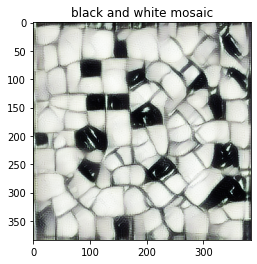

colorful pearls


  0%|          | 0/100 [00:00<?, ?it/s]

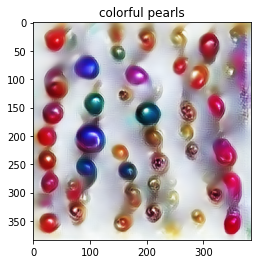

starry night


  0%|          | 0/100 [00:00<?, ?it/s]

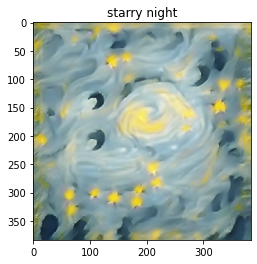

pancake


  0%|          | 0/100 [00:00<?, ?it/s]

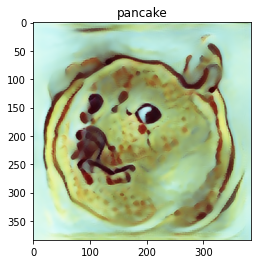

In [ ]:
#@title generate loop
for text in tqdm(text_list.split("\n")):
  print(text)
  tokens = clip.tokenize([text]).to(device)
  code = style_code.clone()
  code.requires_grad_()
  optimizer = torch.optim.Adam([code],lr=lr)

  saved_code = []
  saved_result = []

  for idx in tqdm(range(optimize_steps)):
    result = G(content_tensor, code)
    
    aug_result = aug_fun(result)
    
    c_loss = torch.mean(clip_loss(aug_result, tokens))
    l2_loss = torch.sum((code-style_code)**2)

    loss = clip_loss_weight*c_loss + l2_loss_weight*l2_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (idx+1)%save_step == 0:
      saved_code.append(code.detach())
      saved_result.append(result.detach())
  
  
  plt.imshow(
    np.asarray(T.ToPILImage()(result.squeeze()))
  )
  plt.title(text)
  plt.show()
  
  imageio.mimwrite(f"{save_folder}/{text}.gif", [*map(tensor_to_numpy_image, saved_result)])

In [ ]:
from IPython.display import display
from IPython.display import Image as IPython_Image
import glob
import os

In [ ]:
for filepath in sorted(glob.glob(f"{save_folder}/*.gif"), key=os.path.getmtime):
  print(filepath)
  display(IPython_Image(open(filepath,'rb').read()))

Output hidden; open in https://colab.research.google.com to view.